In [1]:
import pandas

converters = { 'Embarked': lambda s: s if s != '' else 'Unknown' }
df = pandas.read_csv('data/Titanic/titanic-train.csv', na_filter=True, converters = converters)
df.head(5)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
import sklearn
import sklearn.preprocessing

sex_codec = sklearn.preprocessing.LabelEncoder()
embarked_codec = sklearn.preprocessing.LabelBinarizer()
imputer = sklearn.preprocessing.Imputer()

embarked_codec.fit(df.Embarked)
embarked_columns = ['embarked_' + (s if s != '' else 'unknown')
                    for s in embarked_codec.classes_]

df_with_encodings = pandas.concat([df, 
                    pandas.DataFrame(sex_codec.fit_transform(df.Sex), columns = ['SexEncoded']),
                    pandas.DataFrame(embarked_codec.transform(df.Embarked), columns=embarked_columns)],
                   axis=1)
df_with_encodings.head(5)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SexEncoded,embarked_C,embarked_Q,embarked_S,embarked_Unknown
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,0,0,1,0


# Select the features and define the targets

In [3]:
feature_names = ['Pclass',
                 'SexEncoded',
                 'Age',
                 'SibSp',
                 'Parch',
                 'Fare',
                 'embarked_Unknown',
                 'embarked_C', 
                 'embarked_Q', 
                 'embarked_S']

features = imputer.fit_transform(df_with_encodings[feature_names])
target = df['Survived']

# Modify Tuning Parameters Here

In [4]:
import sklearn.tree

classifier = sklearn.tree.DecisionTreeClassifier(max_depth=None,
                                                 max_leaf_nodes=7,
                                                 max_features=None,
                                                 min_samples_leaf = 25)
classifier.fit(features, target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=7, min_samples_leaf=25,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [5]:
importances = pandas.DataFrame(sorted(zip(classifier.feature_importances_, feature_names), reverse=True),
                               columns = ['Importance', 'Feature'])
importances.head(len(feature_names))

,Importance,Feature
0,0.651349,SexEncoded
1,0.163133,Pclass
2,0.111669,Fare
3,0.059349,Age
4,0.014499,Parch
5,0.000000,embarked_Unknown
6,0.000000,embarked_S
7,0.000000,embarked_Q
8,0.000000,embarked_C
9,0.000000,SibSp


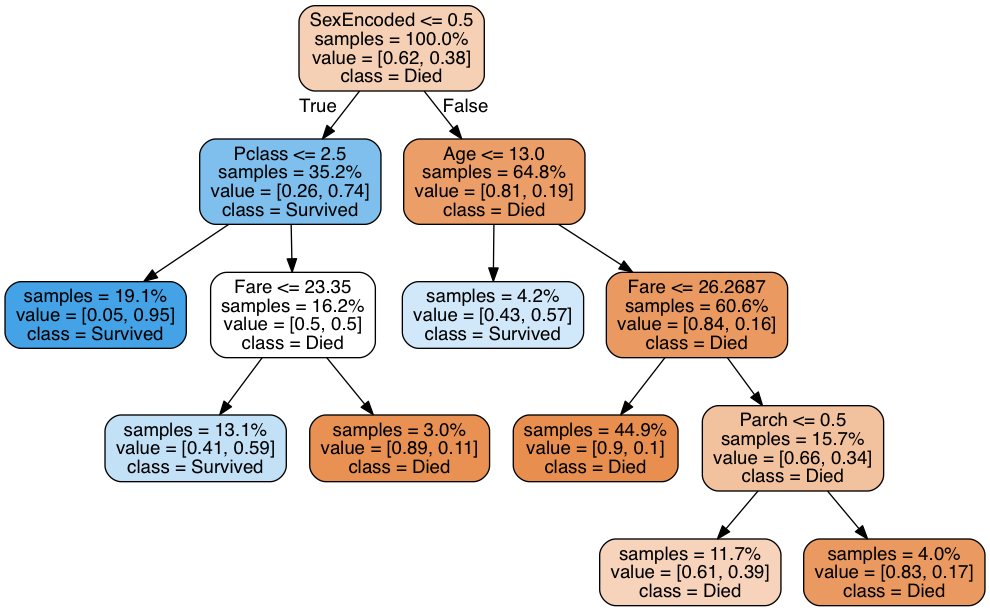

In [6]:
import pydotplus
from IPython.display import Image  
sklearn.tree.export_graphviz(classifier, out_file='tree.dot',
                             class_names = ['Died', 'Survived'],
                             proportion=True,
                             filled=True,
                             leaves_parallel=False,
                             impurity=False,
                             rounded=True,
                         feature_names=feature_names) 
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())  


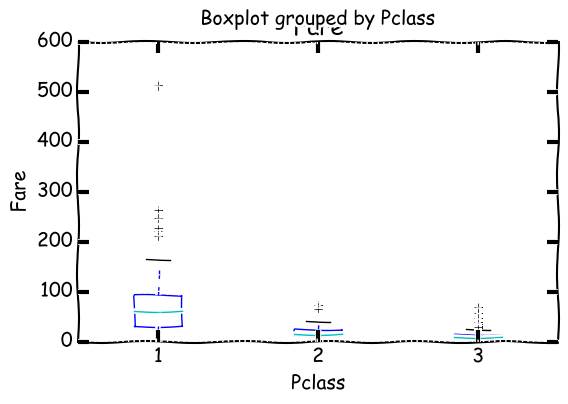

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.xkcd()
df.boxplot(column='Fare', by='Pclass')
plt.ylabel('Fare')

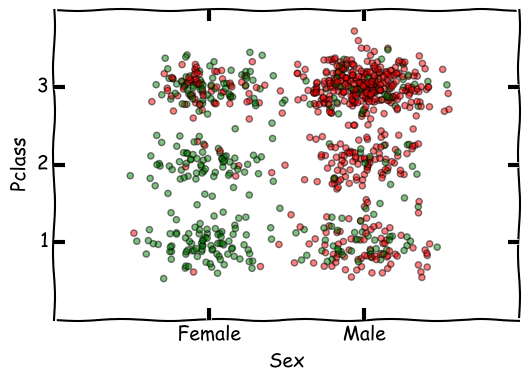

In [8]:
import numpy

def jittered(vector):
    return vector + numpy.random.normal(0.0, 0.20, len(vector))

plt.scatter(jittered(df_with_encodings.SexEncoded),
            jittered(df_with_encodings.Pclass),
            c=['green' if s == 1 else 'red' for s in df_with_encodings.Survived],
           alpha=0.5)
plt.xlabel('Sex')
plt.xticks([0.0, 1.0], ['Female', 'Male'])
plt.ylabel('Pclass')
plt.yticks([1, 2, 3], ['1', '2', '3']);

('size: ', Survived
0    24
1     3
dtype: int64)


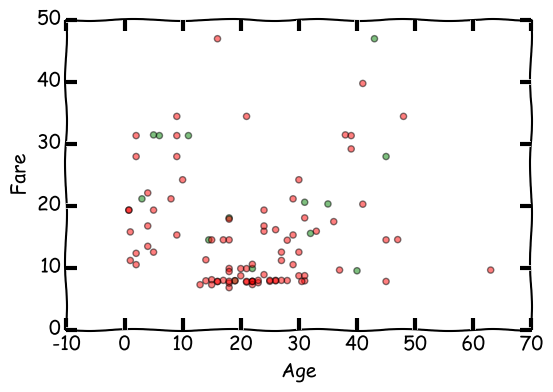

In [9]:
just_men = df_with_encodings[df.Sex == 'male']
just_women = df_with_encodings[df_with_encodings.Sex == 'female']
third_class_women = df_with_encodings[(df_with_encodings.Pclass>=3.0) & (df_with_encodings.Sex == 'female')]
third_class_women_low_fare = df_with_encodings[(df_with_encodings.Pclass>=3.0) & 
                                               (df_with_encodings.Sex == 'female') &
                                               (df_with_encodings.Fare <= 23.35)]
third_class_women_high_fare = df_with_encodings[(df_with_encodings.Pclass>=3.0) & 
                                               (df_with_encodings.Sex == 'female') &
                                               (df_with_encodings.Fare > 23.35)]
print('size: ', third_class_women_high_fare.groupby('Survived').size())
plt.scatter(third_class_women.Age,
            third_class_women.Fare,
            c=['green' if s == 1 else 'red' for s in just_men.Survived],
           alpha=0.5)

plt.xlabel('Age')
plt.ylabel('Fare')
